Using: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1MB/s]


Epoch 1/100 | Loss: 0.1147
Epoch 2/100 | Loss: 0.0719
Epoch 3/100 | Loss: 0.0641
Epoch 4/100 | Loss: 0.0601
Epoch 5/100 | Loss: 0.0582
Epoch 6/100 | Loss: 0.0565
Epoch 7/100 | Loss: 0.0552
Epoch 8/100 | Loss: 0.0546
Epoch 9/100 | Loss: 0.0538
Epoch 10/100 | Loss: 0.0529
Epoch 11/100 | Loss: 0.0525
Epoch 12/100 | Loss: 0.0518
Epoch 13/100 | Loss: 0.0517
Epoch 14/100 | Loss: 0.0513
Epoch 15/100 | Loss: 0.0506
Epoch 16/100 | Loss: 0.0503
Epoch 17/100 | Loss: 0.0501
Epoch 18/100 | Loss: 0.0499
Epoch 19/100 | Loss: 0.0500
Epoch 20/100 | Loss: 0.0495
Epoch 21/100 | Loss: 0.0489
Epoch 22/100 | Loss: 0.0489
Epoch 23/100 | Loss: 0.0490
Epoch 24/100 | Loss: 0.0487
Epoch 25/100 | Loss: 0.0482
Epoch 26/100 | Loss: 0.0481
Epoch 27/100 | Loss: 0.0482
Epoch 28/100 | Loss: 0.0482
Epoch 29/100 | Loss: 0.0477
Epoch 30/100 | Loss: 0.0479
Epoch 31/100 | Loss: 0.0478
Epoch 32/100 | Loss: 0.0474
Epoch 33/100 | Loss: 0.0473
Epoch 34/100 | Loss: 0.0471
Epoch 35/100 | Loss: 0.0470
Epoch 36/100 | Loss: 0.0471
E

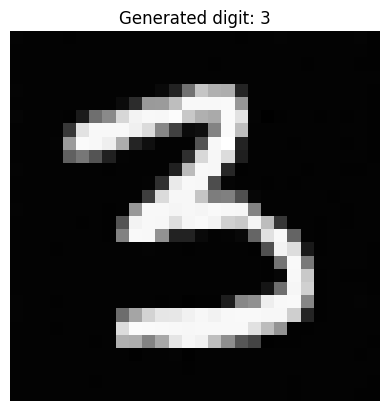

In [ ]:
# ============================================================
# 🧠 CONDITIONAL DIFFUSION MODEL (MNIST Example) - FIXED
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import math

# ============================================================
# 1️⃣ Setup
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

IMAGE_SHAPE = (1, 28, 28)
BATCH_SIZE = 64
NO_EPOCHS = 100
LR = 0.001
PRINT_FREQ = 2


# ============================================================
# 2️⃣ Data
# ============================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1),  # scale to [-1, 1]
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.squeeze(0)),
])

# ============================================================
# 3️⃣ Diffusion Process
# ============================================================
class DiffusionModel:
    def __init__(self, timesteps=200, start_beta=1e-4, end_beta=0.02, device=device):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(start_beta, end_beta, timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def get_index_from_list(self, vals, t, x_shape):
        batch_size = t.shape[0]
        out = vals.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    def forward(self, x_0, t, device):
        noise = torch.randn_like(x_0)
        sqrt_alpha = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alpha = self.get_index_from_list(torch.sqrt(1 - self.alphas_cumprod), t, x_0.shape)
        x_t = sqrt_alpha * x_0 + sqrt_one_minus_alpha * noise
        return x_t, noise

    @torch.no_grad()
    def backward(self, x, t, model, labels):
        beta_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alpha = self.get_index_from_list(torch.sqrt(1 - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alpha = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)

        pred_noise = model(x, t, labels)
        mean = sqrt_recip_alpha * (x - beta_t * pred_noise / sqrt_one_minus_alpha)
        if t[0] == 0:
            return mean
        noise = torch.randn_like(x)
        sigma = torch.sqrt(beta_t)
        return mean + sigma * noise

# ============================================================
# 4️⃣ Time Embedding
# ============================================================
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half = self.dim // 2
        freq = torch.exp(torch.arange(half, device=t.device) * (-math.log(10000) / (half - 1)))
        emb = t[:, None] * freq[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# ============================================================
# 5️⃣ Conditional UNet (FIXED - Correct Channel Dimensions)
# ============================================================
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, num_classes=10, down=True):
        super().__init__()
        self.down = down
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.label_emb = nn.Embedding(num_classes, out_ch)

        if down:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)  # Downsample
        else:
            # FIXED: Correct input channels for upsampling (concatenated)
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)  # Upsample

        self.batchnorm = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, labels):
        h = self.relu(self.conv1(x))
        time_emb = self.relu(self.time_mlp(t))[(...,) + (None,)*2]
        label_emb = self.relu(self.label_emb(labels))[(...,) + (None,)*2]
        h = h + time_emb + label_emb
        h = self.relu(self.batchnorm(self.conv2(h)))
        return self.transform(h)

class UNet(nn.Module):
    def __init__(self, img_ch=1, time_emb_dim=128, num_classes=10):
        super().__init__()
        self.time_emb = SinusoidalPositionEmbeddings(time_emb_dim)

        # Down path
        self.down1 = Block(img_ch, 64, time_emb_dim, num_classes, down=True)
        self.down2 = Block(64, 128, time_emb_dim, num_classes, down=True)

        # Bottleneck
        self.bottleneck_conv1 = nn.Conv2d(128, 128, 3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(128)
        self.bottleneck_time_mlp = nn.Linear(time_emb_dim, 128)
        self.bottleneck_label_emb = nn.Embedding(num_classes, 128)

        # Up path (FIXED: Correct input channels with skip connections)
        self.up1 = Block(256, 128, time_emb_dim, num_classes, down=False)  # 128 + 128 from skip
        self.up2 = Block(192, 64, time_emb_dim, num_classes, down=False)   # 128 + 64 from skip

        self.out = nn.Conv2d(64, img_ch, 1)
        self.relu = nn.ReLU()

    def forward(self, x, t, labels):
        t_emb = self.time_emb(t)

        # Down path with skip connections
        d1 = self.down1(x, t_emb, labels)      # 64 channels, 14x14
        d2 = self.down2(d1, t_emb, labels)     # 128 channels, 7x7

        # Bottleneck
        h = self.relu(self.bottleneck_conv1(d2))
        time_emb = self.relu(self.bottleneck_time_mlp(t_emb))[(...,) + (None,)*2]
        label_emb = self.relu(self.bottleneck_label_emb(labels))[(...,) + (None,)*2]
        h = h + time_emb + label_emb
        b = self.relu(self.bottleneck_bn(self.bottleneck_conv2(h)))  # 128 channels, 7x7

        # Up path with skip connections
        u1 = torch.cat([b, d2], dim=1)         # Concatenate: 128 + 128 = 256 channels
        u1 = self.up1(u1, t_emb, labels)       # 128 channels, 14x14

        u2 = torch.cat([u1, d1], dim=1)        # Concatenate: 128 + 64 = 192 channels
        u2 = self.up2(u2, t_emb, labels)       # 64 channels, 28x28

        return self.out(u2)

# ============================================================
# 6️⃣ Training
# ============================================================
diffusion = DiffusionModel(device=device)
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(NO_EPOCHS):
    model.train()
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=device).long()
        x_t, noise = diffusion.forward(x, t, device)
        pred_noise = model(x_t, t, y)
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{NO_EPOCHS} | Loss: {np.mean(losses):.4f}")

# ============================================================
# 7️⃣ Sampling (Generate digits)
# ============================================================
model.eval()

label = torch.tensor([3]).to(device)  # generate a "9"
x = torch.randn((1, 1, 28, 28)).to(device)
for i in reversed(range(diffusion.timesteps)):
    t = torch.full((1,), i, dtype=torch.long, device=device)
    x = diffusion.backward(x, t, model, label)
    if i % 50 == 0:
        print(f"Step {i}")

plt.imshow(reverse_transform(x[0].cpu()).detach().cpu(), cmap="gray")
plt.title("Generated digit: 3")
plt.axis("off")
plt.show()
